In [17]:
library(sensitivity)
library(tidyr)
source("../augmented_utils.R")

parallel = TRUE
registerDoParallel(cores = 5)

In [16]:
options(repr.plot.width = 10, repr.plot.height = 6)


### CtoR function to associate the best representatives to a given clustering

In [4]:
vec = seq(10^-10,1-10^-10,l=5000) #just a vector to estimate integral

try_unif_1d = function(samp, delta = NULL){ #this compute the optimal parameters of the 1D uniform
  quantiles_vec = quantile(samp, vec) #computation of the empirical quantile function on [0,1]
  if(is.null(delta)){ #if the width of the support is free
    u_bound = mean(quantiles_vec*(6*vec-2)) #estimate upper bound
    l_bound = mean(quantiles_vec*(-6*vec+4)) #estimate lower bound
  }
  else{ #if width of support is given
    l_bound = mean(quantiles_vec-delta/2) #estimate lower bound
    u_bound = l_bound+delta #estimate upper bound
  }
  return(matrix(c(l_bound, u_bound)))
  
}

CtoR = function(clusts, only_bornes = TRUE, n_sample = 500, return_error = FALSE){ #function that associate the best representative, either a dirac or a uniform on each marginal
  rep = list()
  law = list()
  local_errors = c() 
  for(j in 1:length(clusts)){ #for each cluster, the optimal representative will be provided
    mat = NULL
    law_j = c()
    diss_tot = 0 #quantization error
    for(k in 1:ncol(clusts[[j]])){ #for each marginal
      diss_unif = 10^5
      for(delta in c(1/4,1/2,3/4,1)){ #try the support width 0.25,0.5,0.75 and 1
       unif_prov = try_unif_1d(clusts[[j]][,k], delta = delta) #get the uniform with given width
       unif_tilde_prov = from_law_to_sample(list(unif_prov), law = list("unif"), n = n_sample)[[1]] #get sample associated with this uniform
       diss_unif_prov = wasserstein1d(unif_tilde_prov, clusts[[j]][,k],p=2) #compute wasserstein distance between the marginal and the uniform
       if(diss_unif_prov < diss_unif){ #if this uniform is the best, save it
         unif = unif_prov
         unif_tilde = unif_tilde_prov
         diss_unif = diss_unif_prov
       }
      }
     dirac = mean(clusts[[j]][,k]) #try dirac representative
     dirac = matrix(c(dirac, dirac)) 
     dirac_tilde = from_law_to_sample(list(dirac), law = list("dirac"), n = n_sample)[[1]]
     diss_dirac = wasserstein1d(dirac_tilde, clusts[[j]][,k],p=2) #compute wasserstein distance between the marginal and the dirac
     if(diss_dirac > diss_unif){ #if the dirac is not the best representative, keep uniform
      if(!only_bornes){mat = cbind(mat, unif_tilde)} #only_bornes=TRUE indicates that the only the parameters of the representatives are returned. If false, then a sample is returned for the representative
       else{mat = cbind(mat, unif)}
       law_j = c(law_j, "unif")
       diss_tot = diss_tot + diss_unif^2
     }
     else{ #if dirac is the best representative, save it
       if(!only_bornes){mat = cbind(mat, dirac_tilde)}
       else{mat = cbind(mat, dirac)}
       law_j = c(law_j, "dirac")
       diss_tot = diss_tot + diss_dirac^2
     }
    }
    rep[[j]] = mat
    law[[j]] = law_j
    local_errors = c(local_errors, sqrt(diss_tot))
  }
  res = list(rep, law)
  if(return_error){res = c(res,  list(local_errors, sapply(clusts, nrow)))}
  return(res)
}




### Function to initialize the AQ algorithm 

In [ ]:

initialize_algo = function(l,d, multistart = 1){ #function to propose initial mixture (randomly selected)
    starts = list()
    for(start in 1:multistart){ #multistart
        weights = rep(1/l, l = l) #equal weights
        all_law = list()
        all_rep = list()
        for(xx in 1:l){
            size_unif = sample(x= c(0,0.25,0.5, 0.75,1), size = d) #select size of uniform (0 is dirac)
            repres = runif(n = d, min = 0, max = 1-size_unif) #lower bound of the uniform
            repres = rbind(repres, repres + size_unif) #upper bound
            law = rep("dirac", d) 
            law[which(size_unif >0.001)] = "unif"
            all_rep[[xx]] = repres 
            all_law[[xx]] = law
        }
    starts[[start]] = list(rep = all_rep, law = all_law) 
    }
    return(starts)
}


### Run AQ algorithm

In [ ]:
set.seed(10)

Xsample = as.matrix(read.csv("conditionnal_sample_flood.csv"))[,c(1,4,6,7)]

init = initialize_algo(l = 3, d = 4)[[1]]
res_sensi = augmented_quanti(samp = Xsample, rep = init$rep,vec_prop = c(0.4,0.2,0.1), it_lim = 10,n_sample = 1000,threshold = 0.008, law = init$law, prop_search = 1)
save(res_sensi, file = "res_sensi_flood.RData")


### Plot obtained mixture

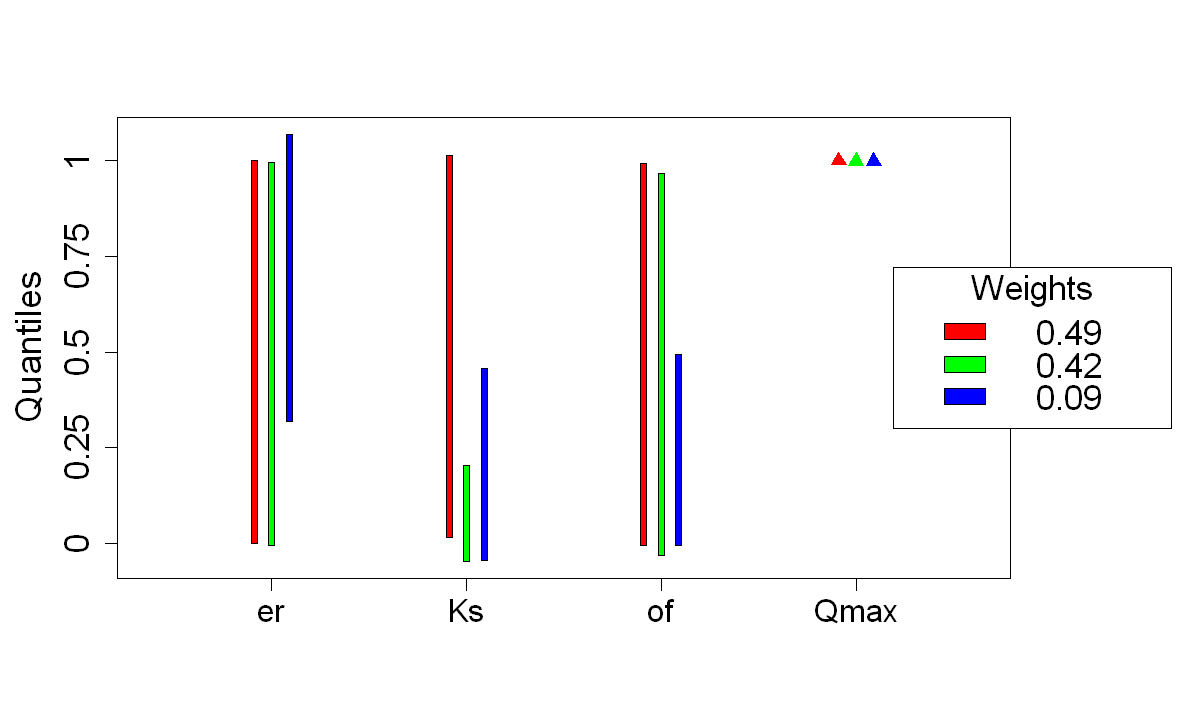

In [27]:
load("res_sensi_flood.RData")
best_sensi = find_best(res_sensi)
df_plot = create_df_plot(best_sensi[[2]], best_sensi[[1]])
plot_hybrid_distrib(df_plot,c("er","Ks","of", "Qmax"), cex_legend = 1.7, ysize = 1.7)
#plot_hybrid_distrib(df_plot,c("er","Ks","of", "Qmax"), cex_legend = 1.7, ysize = 1.7, save = TRUE, save_name = "res_flood.pdf",inset = c(-0.09,0))

### Recompute quantile here

In [5]:
df_flood = read.csv("df_flood.csv") #df flood has 10^6 samples of F(X1), F(X2), F(X3) with the output associated output Y

level_quant = 0.99 #this corresponds to the 0.999% quantile due to truncated sampling
thresh = as.numeric(quantile(df_flood$pred_norm, level_quant))
thresh

[1] 63.82993

### Function to compute HSIC indices with ANOVA-like decomposition

In [ ]:
pairs = t(combn(1:3, 2))

func_hsic = function(it){
    X = df_flood[((it-1)*10^4+1):(it*10^4),1:3] #get 10^4 samples of the inputs variables (except Qmax, not considered here)
    model = function(X){return(as.numeric(df_flood[((it-1)*10^4+1):(it*10^4),5]))} #get associated outputs
    res_hsic = sensiHSIC(model = model, X = X, target=list(c=thresh, type = "exp1side"), anova = list("obj" = "both"), kernelX = "rbf_anova", kernelY = "rbf_anova")  #get hsic indices with the 3 variables
    res = as.numeric(res_hsic$FO[[1]]) #get first order indices
    denom = as.numeric(res_hsic$denom) #get denominator to normalize the 2nd order indices that will be computed
    for(ii in 1:nrow(pairs)){ #for each pair of parameters
        XX = X[,pairs[ii,]] 
        res_hsic = sensiHSIC(model = model, X = XX, target=list(c=thresh, type = "exp1side"), anova = list("obj" = "both"),kernelX = "rbf_anova", kernelY = "rbf_anova") #get hsic indices for this pair of parameter
        interaction = (as.numeric(res_hsic$TO[[1]])[1] - as.numeric(res_hsic$FO[[1]])[1])*as.numeric(res_hsic$denom)/denom # compute the 2nd order index and normalize it
        res = c(res, interaction)
    }
    return(res)
}

### Compute the HSIC indices 

In [ ]:
set.seed(10)

n_iter = 100
results <- foreach(it = 1:n_iter, .combine = "rbind") %dopar% {func_hsic(it)}
results = as.data.frame(results)
colnames(results) = c("er","Ks","of","er-Ks","er-of","Ks-of")
results["er-Ks-of"] = 1-apply(results, 1, sum)

write.csv(results, file = "results_hsic_flood_interactions.csv", row.names = FALSE)


### Plot the results

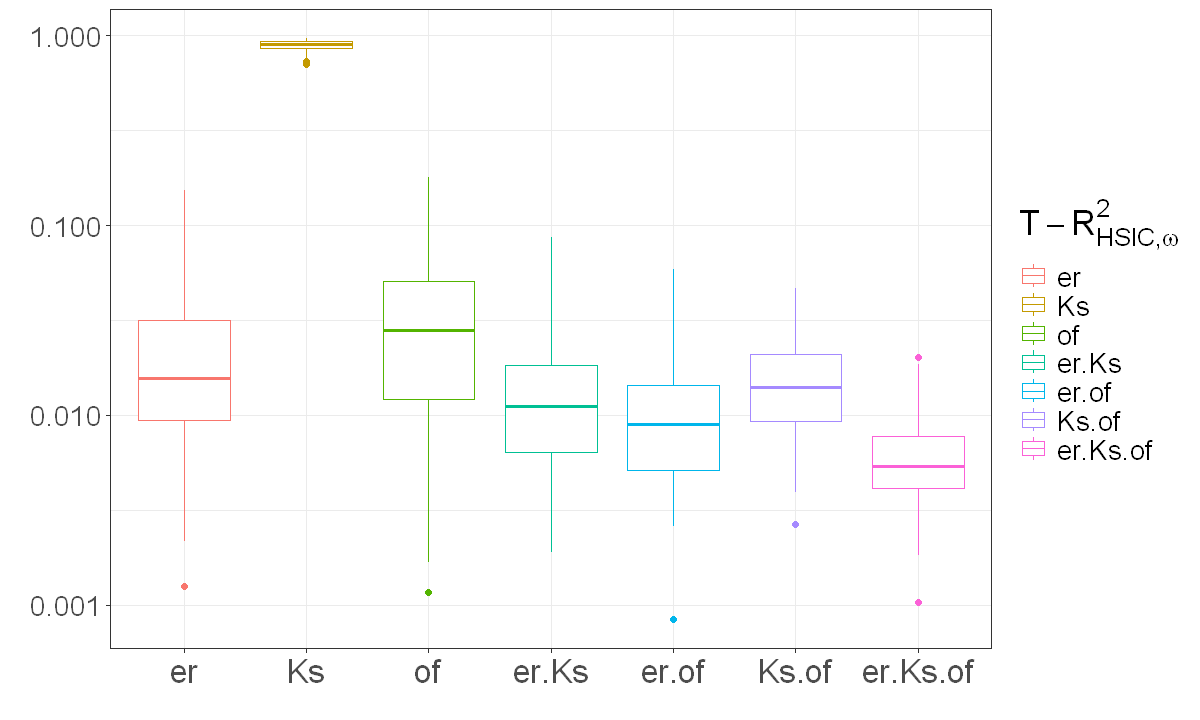

In [28]:
results = read.csv("results_hsic_flood_interactions.csv")
df_long <- pivot_longer(results, cols = everything(), names_to = "Variable", values_to = "Value")
df_long$Variable <- factor(df_long$Variable, levels = unique(df_long$Variable))

# Boxplots côte à côte
p = ggplot(df_long, aes(x = Variable, y = Value, col = Variable)) +
  geom_boxplot() +
  theme_bw() +
  labs(
    x = "", y = "",
    color = expression(T - R[phantom() * paste(plain("HSIC"), ",", omega)]^2)
  ) +
  scale_fill_brewer(palette = "Set2") +
  theme(
    legend.title = element_text(size = 21),  # taille du titre de la légende
    legend.text  = element_text(size = 17),  # taille du texte de la légende
    axis.text.x  = element_text(size = 20),  # taille des ticks en abscisse
    axis.text.y  = element_text(size = 17)   # taille des ticks en ordonnée
  ) +  scale_y_log10()

p

In [13]:
ggsave(filename = "hsic_flood.pdf",plot = p,device = cairo_pdf,width = 10, height = 7, units = "in",dpi = 600)